### Install transformers and datasets

In [1]:
!pip install -U transformers
!pip install -qq datasets
!pip3 install -qq rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 27.1 MB/s eta 0:00:00


In [2]:
!pip install -qq bert-extractive-summarizer

### import required libarries

In [3]:
import os
import logging

import numpy as np

os.environ["gpt2_tokenizerS_PARALLELISM"] = "false"

import random
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelWithLMHead
from datasets import load_dataset
import torch.optim as optim
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cuda:0


In [4]:
from summarizer import Summarizer,TransformerSummarizer

### Set required variables

In [5]:
split_ratio = 0.9 # The split ratio for train and test
max_length = 128  # gpt2_model output maximum length
dataset_batch = 32 # the batchsize for dataset

#### Load gpt-2 model

In [6]:
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2_model = AutoModelWithLMHead.from_pretrained("gpt2")
gpt2_model = gpt2_model.to(device) # move gpt2_model to gpu

/usr/local/lib/python3.9/dist-packages/transformers/models/auto/modeling_auto.py:1322: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


### Dataset preparation
Let's download amamzon reviews dataset using huggingface datsets library.

In [7]:
#downloads and loads the amazon dataset

amazon_dataset = load_dataset("amazon_reviews_multi", split="train")

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1200000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/all_languages/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


In [8]:
#print the total amazon dataset
print(amazon_dataset)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 1200000
})


```python
# Lets have a look at amazon dataset:
-----------------------------------
1. review_id = if of the review
2. product_id = The id for product
3. reviewer_id = The id of person who wrote the review
4. stars = What is the star rating given by customer
5. review_body = full text review
6. review_title = the heading of the review
7. language = The language of th ereview. We are interested in english language
8. product_category = The category of review.
```

#### Pre-processing the dataset


One of the dataset sample looks like this:

In [9]:

print(amazon_dataset[999])

{'review_id': 'de_0037010', 'product_id': 'product_de_0707700', 'reviewer_id': 'reviewer_de_0588468', 'stars': 1, 'review_body': 'Leider ist das Board nach einem knappen halben Jahr in Gebrauch mit durchschnittlicher Nutzung (2-3 mal pro Woche) bereits defekt. Ein Riss macht eine weitere Nutzung unmöglich. Bisher war es ein tolles Sportgerät und hat viel Freude bereitet. Die Lieferung erfolgte auch schnell und unkompliziert. Leider halt nicht von langer dauer.', 'review_title': 'Balance Fitness Board', 'language': 'de', 'product_category': 'sports'}


We can see that the dataset contains other languages, so we filter the dataset to only include english language reviews.

In [10]:
# Filter Amamzon dataset to keep only english language reviews
amazon_dataset = amazon_dataset.filter(lambda example: example['language'].startswith('en'))

Filter:   0%|          | 0/1200000 [00:00<?, ? examples/s]

In [11]:
# we perform pre-processing and analysis of the dataset

amazon_dataset.set_format("pandas")
amazon_dframe = amazon_dataset[:]
# Displays the 20 twenty most common reviews
amazon_dframe["review_title"].value_counts()[:20]

Three Stars       4169
Four Stars        3932
Five Stars        3918
Two Stars         3730
One Star          3435
Disappointed       683
Great product      437
Good               421
Good product       345
Great              345
Poor quality       336
Ok                 327
Nice               300
Meh                290
Cheap              271
Waste of money     252
Good quality       235
Cute               235
Perfect            233
Not worth it       229
Name: review_title, dtype: int64

Visualizing the top twenty most frequent reviews and plotting them

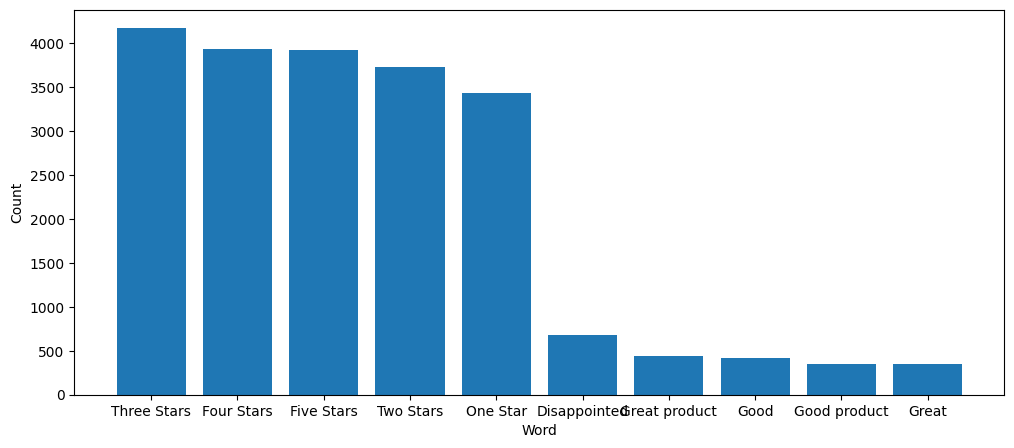

In [12]:
import matplotlib.pyplot as plt

# The table of words and counts
table = {
    "Three Stars": 4169,
    "Four Stars": 3932,
    "Five Stars": 3918,
    "Two Stars": 3730,
    "One Star": 3435,
    "Disappointed": 683,
    "Great product": 437,
    "Good": 421,
    "Good product": 345,
    "Great": 345,
    "Poor quality": 336,
    "Ok": 327,
    "Nice": 300,
    "Meh": 290,
    "Cheap": 271,
    "Waste of money": 252,
    "Good quality": 235,
    "Cute": 235,
    "Perfect": 233,
    "Not worth it": 229
}

# Extract the words and counts from the table
words = list(table.keys())[:10]
counts = list(table.values())[:10]

# Create a new figure
fig = plt.figure(figsize=(12, 5))

# Add a subplot to the figure
ax = fig.add_subplot(1, 1, 1)

# Plot the word counts as a bar chart
ax.bar(words, counts)


# Set the x-axis label
ax.set_xlabel("Word")

# Set the y-axis label
ax.set_ylabel("Count")


# Show the plot
plt.show()

We see some review titles have vastly more representation than others so we filter the dataset to only make it more balanced so the model does'nt overfit.

In [13]:
# Again keep reveiews whose have review_length at least two words
amazon_dataset = amazon_dataset.filter(lambda example: len(example['review_title'].split(' ')) > 2)

Filter:   0%|          | 0/200000 [00:00<?, ? examples/s]

We print out the features of the filtered dataset

In [14]:
print(amazon_dataset)

Dataset({
    features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
    num_rows: 125893
})


In [15]:
def pick_examples(num):
  for i in range(0,num):
    print(amazon_dataset[random.randint(0,10000)])

pick_examples(4)

    review_id          product_id          reviewer_id  stars  \
0  en_0544933  product_en_0669431  reviewer_en_0993464      1   

                                         review_body  \
0  These worked great for awhile. One quit workin...   

                                      review_title language product_category  
0  Seem to be great quality, but they quit working       en         wireless  
    review_id          product_id          reviewer_id  stars  \
0  en_0526707  product_en_0032543  reviewer_en_0629186      1   

                                         review_body  \
0  The tapered fitting on the mount was not large...   

                review_title language product_category  
0  Does not fit visor shaft.       en       automotive  
    review_id          product_id          reviewer_id  stars  \
0  en_0030431  product_en_0602293  reviewer_en_0158311      1   

                                         review_body             review_title  \
0  The product did not come 

Implementing the test train split for the dataset to split the dataset into test and train parts

In [16]:
amazon_dataset = amazon_dataset.train_test_split(
    train_size=split_ratio, test_size=1-split_ratio
)

In [17]:
# The respective test and train splts of the dataset

amazon_dataset

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 113303
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 12590
    })
})

In [18]:
# The number of rows in the training set

len(amazon_dataset["train"]["review_body"])

113303

Appending the Token "TL;DR" to training dataset as GPT-2 is a decoder only model, we need to append the review summary at the end of the main body of text and seperate them with a seperation token so, the model co differentiate between the review and summary.

In [19]:
# Appending the Token "TL;DR" to training datset.

train_reviews = []
for i,j in zip(amazon_dataset["train"]["review_body"], amazon_dataset["train"]["review_title"]):
    train_reviews.append(i + " TL;DR " + j)

Example of the demarcation token between review and summary.

In [20]:
# Example from the dataset.

train_reviews[999]

"They did not germinate. I have tossed the remaining seeds TL;DR Won't buy again."

In [21]:
#calculating the average length of the strings in the dataset.

average_length = sum([len(review.split()) for review in train_reviews])/len(train_reviews)
average_length

48.01846376530189

## Create baseline model

We create a baseline gpt-2 model to compare against the finetuned gpt-2 model. This forms our baseline model and shows how finetuning will effect the overall score and accuracy of the model.

In [22]:
##loading a sample review into gpt2 and checking the summarized text 

GPT2_model_baseline = TransformerSummarizer(transformer_type="GPT2",transformer_model_key="gpt2")
summarization_baseline_model  = GPT2_model_baseline(train_reviews[1], min_length=5)
print(summarization_baseline_model)

Product came and pump does not work. Too much of a hassle to return.


/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
baseline_reviews = [review.split(" TL;DR ")[0] for review in random.sample(train_reviews, 3)]
baseline_reviews

["Pros: + Well-designed fit, buttons click in the sweet spot which is an issue for many 3rd-party cases + Slim design, this is meant to protect against small bumps and scratches, not big drops. Maxboost has other cases for that + Raised edges to prevent screen from touching surface (even with screen protector installed) + All ports accessible, wireless charging works through case Cons: - Case has a very slippery material. This isn't an issue for me personally but if you aren't a very careful person you might want to get a bulkier case",
 'What I liked about this product is that it had a good variety of colors to choose from. I shopped around and other brands did not have that option.',
 'The numbers and markings on the rain gauge should be painted BLACK with a permanent black paint so that the rain gauge would be much easier to read.']

In [24]:
for rev in baseline_reviews:
    print("The Review body : ", rev)
    base_summary = GPT2_model_baseline(rev)
    print("the generated summary : ", base_summary)

The Review body :  Pros: + Well-designed fit, buttons click in the sweet spot which is an issue for many 3rd-party cases + Slim design, this is meant to protect against small bumps and scratches, not big drops. Maxboost has other cases for that + Raised edges to prevent screen from touching surface (even with screen protector installed) + All ports accessible, wireless charging works through case Cons: - Case has a very slippery material. This isn't an issue for me personally but if you aren't a very careful person you might want to get a bulkier case
the generated summary :  Pros: + Well-designed fit, buttons click in the sweet spot which is an issue for many 3rd-party cases + Slim design, this is meant to protect against small bumps and scratches, not big drops. Maxboost has other cases for that + Raised edges to prevent screen from touching surface (even with screen protector installed) + All ports accessible, wireless charging works through case Cons: - Case has a very slippery mat

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


As we can see from the generated summaries the baseline model is not very good it often repeats the entire review from the datset or does'nt produce any output, with minimal changes to the original sentence. The model needs to be trained on the task of summarizaion to produce actual meaningful summaries.

### Create model parameters and tokenize dataset 

In [25]:
# Define the hyperparameters of the model

params = gpt2_model.parameters()
torch_optimizer = optim.Adamax(params, lr=2e-5)

In [26]:
gpt2_tokenizer.encode(" TL;DR ")

[24811, 26, 7707, 220]

In [27]:
length_tldr_token = len(gpt2_tokenizer.encode(" TL;DR "))
length_tldr_token

4

In [28]:
class CreateAmazonDataset(Dataset):
    def __init__(self, review_dataset, gpt2_tokenizer, max_length, length_tldr_token):
        self.max_length = max_length
        self.gpt2_tokenizer = gpt2_tokenizer
        self.end_of_sequence = self.gpt2_tokenizer.eos_token
        self.end_of_sequence_id = self.gpt2_tokenizer.eos_token_id
        self.review_dataset = review_dataset
        self.processed_data = []
    
        for data in self.review_dataset:
            # Add end_of_sequence i.e. "tl;dr" token at the end of each tokenized_review body.
            tokenized_review = self.gpt2_tokenizer.encode(data + self.end_of_sequence)
            
            # adjust tokenised data accordingly
            len_token_tokenized_review = len(tokenized_review) - length_tldr_token
            if len_token_tokenized_review > self.max_length:        # truncate
                processed_data = tokenized_review[:self.max_length + 3]+[self.end_of_sequence_id] 
            elif len_token_tokenized_review < self.max_length:      # pad
                difference = self.max_length - len_token_tokenized_review
                processed_data = tokenized_review + [self.end_of_sequence_id] * difference
            else:
                processed_data = tokenized_review

            # Append final data
            self.processed_data.append(torch.tensor(processed_data))

    def __len__(self):
        return len(self.processed_data)


    def __getitem__(self, item):
        return self.processed_data[item]

In [29]:
# Call the above function to tokenize the datset to feed into the torch dataloader

torch_data = CreateAmazonDataset(train_reviews, gpt2_tokenizer, max_length, length_tldr_token)


In [30]:
len(torch_data)

113303

In [31]:
#defining the dataloader to input our data

torch_data_loader = DataLoader(torch_data, batch_size=dataset_batch, shuffle=True, drop_last=True)

In [32]:
#scheduler = torch.optim.lr_scheduler.ExponentialLR(torch_optimizer, gamma=0.9)

def train_summarizer(gpt2_model, torch_optimizer, data_loader, epochs):    
    for epoch in range(epochs):
        for _index, batch in enumerate(data_loader):
            with torch.set_grad_enabled(True):
                torch_optimizer.zero_grad()
                batch = batch.to(device)
                output = gpt2_model(batch, labels=batch)
                loss = output[0]
                loss.backward()
                torch_optimizer.step()
                if _index % 100 == 0:
                    #print("loss: %f, %d"%(loss, _index))
                    print(f"Batch id : {_index}, loss : {loss}")
        #scheduler.step()
            

In [33]:
train_summarizer(gpt2_model=gpt2_model, 
                torch_optimizer=torch_optimizer, 
                data_loader=torch_data_loader, 
                epochs=1)

Batch id : 0, loss : 10.072525024414062
Batch id : 100, loss : 2.0169575214385986
Batch id : 200, loss : 1.510271430015564
Batch id : 300, loss : 1.7048115730285645
Batch id : 400, loss : 1.4677811861038208
Batch id : 500, loss : 1.3601222038269043
Batch id : 600, loss : 1.5777604579925537
Batch id : 700, loss : 1.4764149188995361
Batch id : 800, loss : 1.468637228012085
Batch id : 900, loss : 1.197643756866455
Batch id : 1000, loss : 1.4801408052444458
Batch id : 1100, loss : 1.3962368965148926
Batch id : 1200, loss : 1.5126264095306396
Batch id : 1300, loss : 1.5213032960891724
Batch id : 1400, loss : 1.3292874097824097
Batch id : 1500, loss : 1.6009448766708374
Batch id : 1600, loss : 1.2329390048980713
Batch id : 1700, loss : 1.5826964378356934
Batch id : 1800, loss : 1.2987730503082275
Batch id : 1900, loss : 1.1290966272354126
Batch id : 2000, loss : 1.3834508657455444
Batch id : 2100, loss : 1.4605919122695923
Batch id : 2200, loss : 1.5798676013946533
Batch id : 2300, loss : 1.

In [34]:
# Saving the model weights, so we dont have to train the model again and again while running it

torch.save(gpt2_model.state_dict(), "gpt2_model.pth")
print("Saved PyTorch Model State to gpt2_model.pth")

Saved PyTorch Model State to gpt2_model.pth


In [35]:
# loads the saved model

model = gpt2_model
model.load_state_dict(torch.load("gpt2_model.pth"))

<All keys matched successfully>

In [36]:
from torch import softmax, topk, sum, tensor
def topk_tokenids(probs, n=9):
    # scores to probabilities
    probabilities = softmax(probs, dim= -1)
    
    tokens_probabilities, top_indices = topk(probabilities, k=n)

    tokens_probabilities = tokens_probabilities / sum(tokens_probabilities)

    tokens_probabilities = tokens_probabilities.cpu().detach().numpy()

    rand_prob = np.random.choice(n, 1, p = tokens_probabilities)
    tokenId = top_indices[rand_prob][0]

    return int(tokenId)

In [37]:
def gpt2_model_infer(gpt2_model, gpt2_tokenizer, review, max_length=15):

    review_encoded = gpt2_tokenizer.encode(review)
    result = review_encoded
    initial_input = tensor(review_encoded).unsqueeze(0).to(device)

    with torch.set_grad_enabled(False):

        output = gpt2_model(initial_input)

        logits = output.logits[0,-1]

        result.append(topk_tokenids(logits))

        for _ in range(max_length):
            
            input = tensor(result).unsqueeze(0).to(device)
            output = gpt2_model(input)
            logits = output.logits[0,-1]
            res_id = topk_tokenids(logits)

            if res_id == gpt2_tokenizer.eos_token_id:
                return gpt2_tokenizer.decode(result)
            else: 
                result.append(res_id)
                
    # IF no EOS is generated, return after the max_len
    return gpt2_tokenizer.decode(result)

In [59]:
few_reviews = [review.split(" TL;DR ")[0] for review in random.sample(train_reviews, 5)]
few_reviews

['This item arrived broken. Bout for my son. Cannot give it to him. The wheels and bar are cracked/broken in half. Very disappointed! I would like to return for a refund but they won’t let me. Not happy!',
 'This was the third pair that I returned because they did not fit (the first two pairs were the same size). I received a full refund for those, but not for these! I WILL NEVER BUY FROM THEM, AGAIN!!! EVER!',
 'Love the design, chips a little on the strap but expected for the price. Holds what I need well',
 "They're OK but a little difficult to attach to bag. They'd be fine if you were doing this at home but trying to wrangle laptop bag and secure without the little cords popping off while trying to get through the airport is a bit more of a chore than I expected. They're just OK, not great. Learning curve to figure it out the first time; be patient and reread the limited directions and poor pictures.",
 "I had one of these EXACT spinners and I sold it in a garage sale thinking I wa

In [60]:
for review in few_reviews:
    summaries = set()
    print("The Review body : ", review)
    while len(summaries) < 3:
        summary = gpt2_model_infer(gpt2_model, gpt2_tokenizer, review + " TL;DR ").split('TL;DR')[1].strip()
        print("the generated summary : ", summary)
        if summary not in summaries:
            summaries.add(summary)

The Review body :  This item arrived broken. Bout for my son. Cannot give it to him. The wheels and bar are cracked/broken in half. Very disappointed! I would like to return for a refund but they won’t let me. Not happy!
the generated summary :  !!!!
the generated summary :  !!! broken
the generated summary :  !!!!!!!!!!!!!
The Review body :  This was the third pair that I returned because they did not fit (the first two pairs were the same size). I received a full refund for those, but not for these! I WILL NEVER BUY FROM THEM, AGAIN!!! EVER!
the generated summary :  !!! Never received a refund!
the generated summary :  ????????????????????
the generated summary :  !!! I never received a full refund
The Review body :  Love the design, chips a little on the strap but expected for the price. Holds what I need well
the generated summary :  ive been using for years
the generated summary :  !!!
the generated summary :  iced it up
The Review body :  They're OK but a little difficult to atta

In [ ]:
# Add rogue score

# Test data rouge score

In [43]:
from rouge import Rouge

In [44]:
test_reviews = amazon_dataset["test"]["review_body"]

Genreating the baseline summaries using the baseline model

In [45]:
test_gen_summaries = []

for review in test_reviews[:20]:
    summary = GPT2_model_baseline(review, min_length=10)
    summary = summary.split('.')[0]
    test_gen_summaries.append(summary)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

Generating the summaries using the finetuned model

In [46]:
test_generated_summaries = []

for review in test_reviews[:100]:
    summary = gpt2_model_infer(gpt2_model, gpt2_tokenizer, review + " TL;DR ").split('TL;DR')[1].strip()
    test_generated_summaries.append(summary)

In [47]:
test_generated_summaries[:5]

['??????',
 'ive been looking for a good bed for awhile now..',
 '!!!!!!',
 'ive got this for me.',
 '!!!!']

In [48]:
# cleaning up the generated summaries tokens
import re

indices_to_remove = []
# The regular expression pattern to match
pattern = r"^[A-Za-z][\w\s]+$"

# The list of strings to match against the pattern


# Compile the regular expression pattern
regex = re.compile(pattern)

# Loop through the strings and match each one against the pattern
for _index,value in enumerate(test_generated_summaries):
    # Check if the string matches the pattern
    match = regex.match(value)
    # If the string matches the pattern, print it
    if match:
      print(value)
    else:
        indices_to_remove.append(_index)

gpt2_summary = test_gen_summaries
baseline_summaries = test_generated_summaries
actual_s = amazon_dataset["test"]["review_title"]
actual_summaries = actual_s[:100]

for i in sorted(indices_to_remove, reverse=True):
    del baseline_summaries[i]
    del actual_summaries[i]

ive been looking for a better product
iced hot and tasty
ive been having a hard time getting my nails on
ive not had this problem for a long time
ive been using this for a few months
ive been using it a lot of my day
ive never had a problem with the panties
ive had to switch the Velcro in the hat and I am not happy
I had the waist altered they fit excellent
icky bulbs but nothing like the original sticker
ive been wearing these for about 2 months now
ive only had them for a couple days but now they are great for my son
icky spicy taste
ive not been able to charge my phone for more than 1 day
ive not been used yet
ive used it in my bedroom


In [49]:
## the generated summaries from the GPT-2 code

#gen_summaries

In [50]:
# actual summaries in the test data

#actual_summaries

In [51]:
## Converting the actual summaries into a list to evaluate the model

act_summ = []
for summ in actual_summaries:
    act_summ.append(summ)
type(actual_summaries)
type(act_summ)

list

In [52]:
## checking if both the lists have same number of ntries before generating score
len(baseline_summaries) == len(act_summ)

True

Generating the rouge score for the baseline model

In [53]:
rouge = Rouge()

baseline_scores = rouge.get_scores(baseline_summaries, act_summ, avg=True)

In [54]:
print("Baseline Rouge scores : ")
for key, value in baseline_scores.items():
    print(key , ": ",  value)

Baseline Rouge scores : 
rouge-1 :  {'r': 0.06455090048840048, 'p': 0.07407852564102563, 'f': 0.0658514475117419}
rouge-2 :  {'r': 0.020833333333333332, 'p': 0.0375, 'f': 0.026785713998724488}
rouge-l :  {'r': 0.06455090048840048, 'p': 0.07407852564102563, 'f': 0.0658514475117419}


In [55]:
test_summaries = []
for reviews in test_reviews[:20]:
    test_summaries.append(reviews)

Generating the rouge score for the finetuned model summaries

In [56]:
finetuned_score  = rouge.get_scores(gpt2_summary, test_summaries, avg=True)

In [57]:
print("Test Rouge scores : ")
for key, value in finetuned_score.items():
    print(key , ": ",  value)


Test Rouge scores : 
rouge-1 :  {'r': 0.6002594805405798, 'p': 1.0, 'f': 0.697322590870836}
rouge-2 :  {'r': 0.5654461953366353, 'p': 1.0, 'f': 0.6597756467293405}
rouge-l :  {'r': 0.6002594805405798, 'p': 1.0, 'f': 0.697322590870836}
